# Ensemble Learning & Random Forests

## Introduction

- *Wisdom of the crowd*: aggregate is better than an expert's opinion
- Group of predictors = *Ensemble* (e.g. Group of DT = Random Forest)
- Associated Learning Algorithm = *Ensemble Method*
- Typically used at the end of the project (already have a few good predictors and want to combine them)

In [ ]:
from sklearn.datasets import load_wine as load_data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

dataset = load_data()
_label = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
_target = dataset['target']

X_train, X_test, y_train, y_test = train_test_split(_label, _target)

## Voting Classifiers

- Majority-vote classifier = Hard voting classifier
- *Often* Accuracy(Voting Classifier) > Accuracy(Best classifier in the Ensemble)
- Ensemble of *Weak Learners* can be a *Strong learner* (high accuracy ⇐ Sufficient numbers and sufficiently diverse)

- Why? Law of Large numbers!
 - 51% biased coin (1,000 tosses ⇒ 75% , 10,000 tosses ⇒ 97% (Prob of head majority))
 - Eventually the ratio (observed) of heads gets closer to the probability (theoretical estimate) of heads.
 - Similarly, While a single classifier would give us 51% accuracy, 1000 classifiers ⇒ 75% accuracy and 10,000 classifiers ⇒ 97% accuracy.
 - **Only true if the classifiers are** *perfectly independent*, with *uncorrelated errors* (Not the case, cause they are trained on the same data 😞)
    - One way to get diverse classifiers, is to train them using *different algorithms*

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

C:\Users\hursh\miniconda3\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__:30s}", f"{accuracy_score(y_test, y_pred):.4f}", sep="\t")


C:\Users\hursh\miniconda3\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hursh\miniconda3\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression            	0.9333
RandomForestClassifier        	1.0000
SVC                           	0.6000
VotingClassifier              	0.9333


- Voting classifier outperforms all individual classifier
- *Soft voting* (valid for those classifiers with `predict_proba()` method) :  predict the class with the highest class probability averaged over all the individual classifiers. `voting="soft"` (higher accuracy ⇐ Higher weight to more confident votes)

## 1. Bagging & Pasting

- Diversify classifiers, two ways:
 - Different training algorithms
 - Same training algorithm on different *random subsets* of the training set

- Two types of sampling (for random subset selection)
 - Sampling with replacement (called "bootstrapping" in statistics): *__bootstrap aggregating__* or **Bagging** in short
 - Sampling without replacement: **Pasting**

- Aggregation of the prediction of all predictors
 - *statistical mode* (most frequent prediction) for classification
 - *statistical mean* for regression
 - Since bootstrapped, each individual predictor has more bias: But aggregating reduces both bias and variance.

So, the ensemble method has similar bias but lesser variance than an individual predictor

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,# num of DT Classifiers
    max_samples= 100, # training instances randomly sampled
    bootstrap=True, # True for bagging, False for Pasting
    n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- If the base classifier can estimate class probability then `BaggingClassifier` uses "soft" voting by default (else "hard" voting)
- The ensemble's prediction generalizes better (works better on test set)
- Comparable bias (roughly same number of errors on the training set) but lesser variance (decision boundary is less irregular)
- Diversity due to random selection ⇒ Less correlation ⇒ Reduced variance

### Out-of-Bag Evaluation

- $m$ is the size of the training set.
- 37% of the training instances (on-average, for an individual predictor) will not be seen by it. This set is called *out-of-bag* instances. (not the same instances for all predictors)
- Use `oob_score=True` to use this set as a validation set and give scores automatically for the trained ensemble

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=1, oob_score=True
)

bag_clf.fit(X_train, y_train)
print(f"Bagging Classifier is likely to achieve {bag_clf.oob_score_:.2%} accuracy on test set")

Bagging Classifier is likely to achieve 96.99% accuracy on test set


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print(f"Actual score: {accuracy_score(y_test, y_pred):.2%}")

Actual score: 100.00%


The decision function (here, `predict_proba`, probabilities of training instances) is available through `oob_decision_function_` variable

In [ ]:
bag_clf.oob_decision_function_[:10]

array([[0.20348837, 0.02906977, 0.76744186],
       [0.        , 0.57142857, 0.42857143],
       [0.        , 0.70481928, 0.29518072],
       [0.00591716, 0.99408284, 0.        ],
       [0.        , 0.95360825, 0.04639175],
       [0.        , 0.08045977, 0.91954023],
       [0.00564972, 0.2259887 , 0.76836158],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.09139785, 0.01075269, 0.89784946]])

## Random Patches & Random Subspaces

- Not just sampling the *instances*, but also **sampling the features**
 - `max_features`: how many? (like `max_samples`)
 - `bootstrap_features`: with/without replacement? (like `bootstrap`)
 - Useful while dealing with *high-dimensional inputs* (e.g. images)

- **Random Patches method**: sample both instances & features
- **Random Subspaces method**: sample only features (`bootstrap=False, max_samples=1.0`)

- Even more predictor diversity: trade more bias for a lower variance

## Random Forests

"We grow trees!"

- Generally trained via bagging (sometimes pasting)
- `max_samples` is size of training set.
- instead of `BaggingClassifier(DecisionTreeClassifier)` use `RandomForestClassifier`(or Regressor) (more optimized)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    # has (almost) all params of DT + BaggingClassifier
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1
)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_pred, y_pred_rf)

1.0

- Introduces extra randomness while growing trees (not search for the best node but best feature *among the random subset of features*)

- Extra trees
 - Use random thresholds  (rather than searching for the best possible threshold) to consider splitting decision
 - These are **Extremely Random Trees** ensemble (short: Extra-Trees)
 - Faster to train: because finding the best possible threshold is the most time-consuming task

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

extra_rnd_clf = ExtraTreesClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1
)

extra_rnd_clf.fit(X_train, y_train)

y_pred_erf = extra_rnd_clf.predict(X_test)
accuracy_score(y_pred, y_pred_erf)

1.0

- Find the relative importance of each feature.
- By assessing, how much the feature-use reduces impurity on average (across the forest)
- Scores are scaled to sum to 1.
- Use this to figure out, which features actually matter

In [ ]:
zipped = list(zip(dataset['feature_names'], rnd_clf.feature_importances_ ))
for name, score in sorted(zipped, key= lambda x: x[1], reverse=True):
    print(f"{name:30s} {score: 7.2%}")

proline                         17.03%
color_intensity                 15.07%
flavanoids                      15.04%
alcohol                         13.70%
od280/od315_of_diluted_wines    10.57%
hue                              9.09%
total_phenols                    5.36%
magnesium                        3.86%
alcalinity_of_ash                3.01%
malic_acid                       2.74%
proanthocyanins                  2.11%
ash                              1.28%
nonflavanoid_phenols             1.14%


## 2. Boosting

- Originally *hypothesis boosting*, combines several weak learner into a strong learner
- Each predictor sequantially trained to correct its predecessor


### AdaBoost

- Give more weight to misclassified training instances (predict the training instance and see where the bias lies) and then allow the next predictor to do a better job on those instances.
- After training, each predictor is given different weight depending on their overall accuracy on the weighted training set.
- Cannot be parallelized (or only partially) cause its sequential

- The higher the learning rate $\eta$, the more it will allow outliers to be considered (by giving them more weight $\alpha_j$.

$$
\alpha_j = \eta \log\frac{1-r_j}{r_j}
$$

- If predictor is random guessing then its weight $=0$. <br/>If it is most often wrong then weight $\lt0$

- If correctly  predicted, keep the same weight $w^{(i)}$ else $w^{(i)}\exp(\alpha_j)$

- Predicted class ($k$) = sumproduct($\alpha_j$, prediction) The prediction can be 0/1 thus... we can just sum($\alpha_j$) for class $k$. We select the class which has the highest $\sum_{j=1}^N \alpha_j$


- Multiclass version of AdaBoost: *SAMME* (*Stagewise Addititve Modeling using a Multiclass Exponential loss function*).
 - For two classes, AdaBoost = SAMME
 - When class probabilities can be estimated, it uses SAMME.R (R is "Real") which relies on class probabilities instead of predictions and generally performs better.

 - Adaboost classifier is based on *Decision Stumps*: a DT with `max_depth=1`

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5 # eta
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### Gradient Boosting

- Same sequantial addition of predictors
- Fit the new predictor the the *residual errors* (fit what couldn't be fit)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X, y = _label, _target

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg1.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
X_new = X_test
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([-0.02162968, -0.02162968, -0.02162968, -0.02162968, -0.02162968,
       -0.02162968, -0.02162968, -0.02162968, -0.02162968, -0.02162968,
       -0.02162968, -0.02162968, -0.02162968, -0.02162968, -0.02162968,
       -0.02162968, -0.02162968, -0.02162968, -0.02162968, -0.02162968,
       -0.02162968, -0.02162968, -0.02162968, -0.02162968, -0.02162968,
       -0.02162968, -0.02162968, -0.02162968, -0.02162968, -0.02162968,
       -0.02162968, -0.02162968, -0.02162968, -0.02162968, -0.02162968,
       -0.02162968, -0.02162968, -0.02162968, -0.02162968, -0.02162968,
       -0.02162968, -0.02162968, -0.02162968, -0.02162968, -0.02162968])

For GBRT (Gradient Boosting regression Trees) we can use the class...

- More the learning rate, more trees needed to fit but would generalize better. Regularization technique: *shrinkage*

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- Use early stopping technique to find the **optimal** number of trees
- `staged_predict()` returns an **iterator** over the predictions made by ensemble at each stage of training (one, two, three... trees)

The retrospective method (requiring you to train the full tree before going back and checking what's optimal) goes like this:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=32)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
# staged_predict will return a 2d list...
# output[k] is for n_estimators=k+1 and contains the predictions of the
# y_val given X_val if `n_estimators=k+1`

bst_n_estimators = np.argmin(errors) + 1
bst_n_estimators

32

- Hyperparameter `subsample` to specify the fraction of training instances to be used for training each tree. (Selected randomly)
- Hyperparameter `loss` to control which cost function (Read the Docs)
- Hyperparameter `warm_start=True`, keep existing trees when the `fit()` method is called. (incremental training)

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators # you can change the parameter later too like so...
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)

    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        # new minimum error
        min_val_error = val_error
        error_going_up = 0
    else:
            error_going_up += 1
            if error_going_up == 5:
                break #early stopping

print(min_val_error)
print(gbrt.n_estimators_)

0.05189845904051856
38


### XGBoost

An optimized implementation of Gradient Boosting dev by Tianqui Chen as part of Distributed (Deep) Machine Learning Community (DMLC)
- Extremely fast, scalable, portable
- Important component of winning entries in ML competitions

In [ ]:
import xgboost

xgb_reg = xgboost.XGBClassifier()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[13:18:36] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hursh\miniconda3\envs\tf2\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## 3. Stacking

- Short for *Stacked Generalization*
- Instead of aggregating predictions of all predictors in an ensemble using a trivial function (e.g. hard voting)
- Train a new model (called *blender* or *meta learner*) to perform the aggregation
- Stacking is a.k.a. *blending* if we use a hold-out-set

### Training

- Assume three predictors in this ensemble.
- First Layer
    - Split (training) data into two subsets (training subset and held-out subset)
    - Use first layer's predictors (3 of them trained) to make "clean" predictions (since never seen before) on the hold-out set.

- Second layer:
    - Use these *predicted values* as input features (3D training set) + the target values.
    - You can make the blender using any of the regression methods (Linear, Random Forest), so its possible to make a layer of blenders.

- (Optional) Third Layer:
    - This is the second blending layer.
    - Split data into three subsets instead of two
        - First subset to train predictors
        - The predictors make predictions on the second subset and give new input variables.
        - These input variables are used to train second level of predictors (called blenders (1))
        - Then use the blenders (1) to make predictions on the third subset (2nd hold-out set) and use those predictions as input variables to fit another model (Layer 3) and the given targets of the third subset.
        - The model we fit now is the blender (2) used to blend the predictions of the Layer 2 model.


- DESlib is an implementation


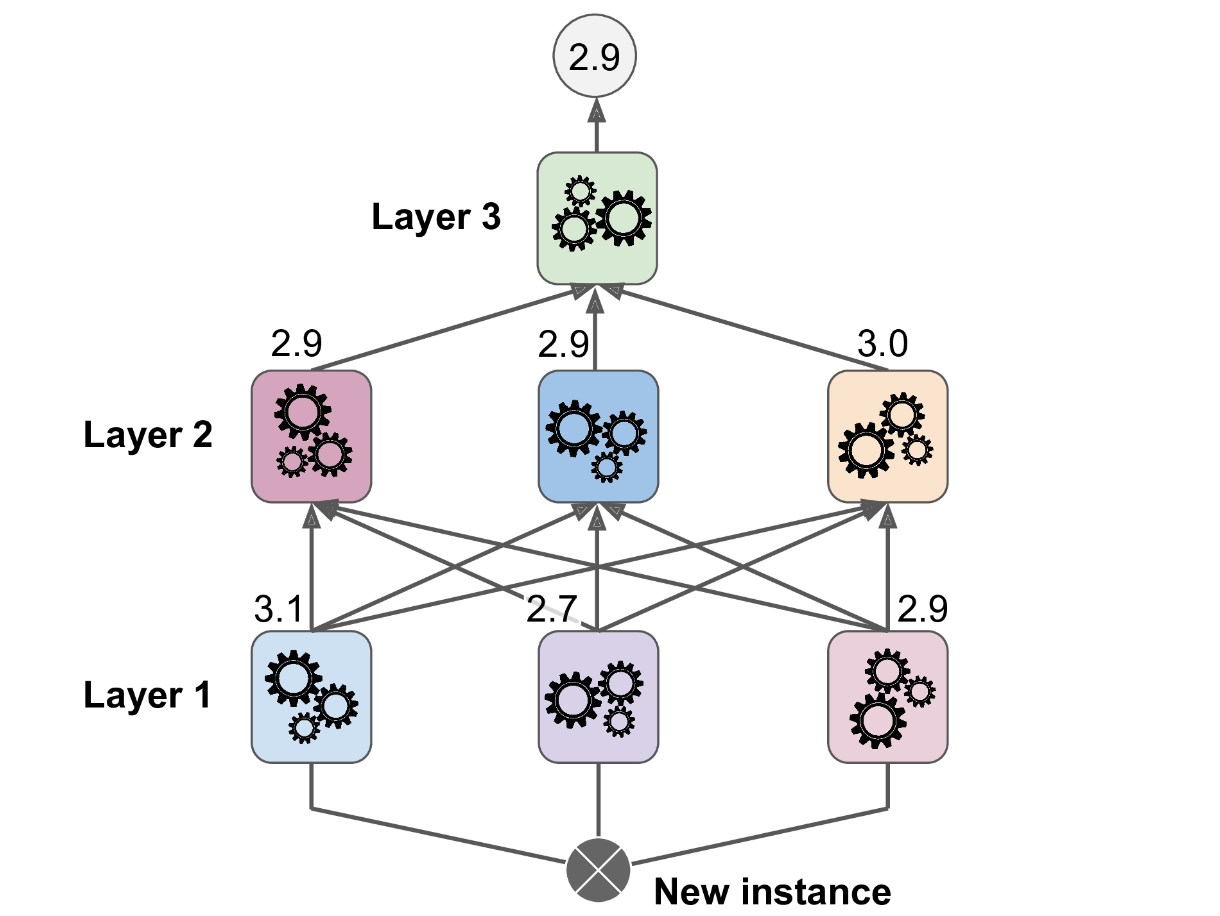